# NDVI Generation Tutorial

This notebook demonstrates how to generate NDVI (Normalized Difference Vegetation Index) for a specific coordinate using STAC (SpatioTemporal Asset Catalog) data.

## Step 1: Import required libraries

In [1]:
import pystac_client
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from pyproj import CRS

## Step 2: Define the coordinate and create a point

In [2]:
# Define the coordinate in EPSG:2056
x, y = 2574187.11, 1204941.00

# Create a GeoDataFrame with the point
point = gpd.GeoDataFrame({'geometry': [Point(x, y)]}, crs='EPSG:2056')

# Transform the point to EPSG:4326 (WGS84) for STAC query
point_wgs84 = point.to_crs('EPSG:4326')
lon, lat = point_wgs84.geometry.x[0], point_wgs84.geometry.y[0]

## Step 3: Connect to the STAC API and search for items

In [3]:
# Connect to the STAC API
catalog = pystac_client.Client.open("https://data.geo.admin.ch/api/stac/v0.9/")

# Swisstopo finish : add the conformance classes :
catalog.add_conforms_to("COLLECTIONS")
catalog.add_conforms_to("ITEM_SEARCH")
#for collection in catalog.get_collections():
#    print(collection.id)


# Search for items
search = catalog.search(
    collections=["ch.swisstopo.swisseo_s2-sr_v100"],
    intersects={"type": "Point", "coordinates": [lon, lat]},
    datetime="2021-08-01/2024-08-31"
)

items = list(search.items())
print(f"Found {len(items)} items")

# Display the first 5 items in the list
for item in items[:5]:  # Change 5 to any number you want to display
    print(item)

Found 267 items
<Item id=2024-04-13t103031>
<Item id=2024-04-25t101559>
<Item id=2024-05-10t102021>
<Item id=2024-05-11t103629>
<Item id=2024-05-20t102021>


## Step 4: Define a function to calculate NDVI

In [4]:
def calculate_ndvi(nir, red):
    return (nir.astype(float) - red.astype(float)) / (nir + red)

## Step 5: Process items and calculate NDVI

In [5]:
results = []

for item in items:
    date = item.properties['datetime']
    
    # Get the URL for the BANDS-10M asset
    bands_10m_key = next(key for key in item.assets.keys() if key.endswith('_bands-10m.tif'))
    bands_10m_url = item.assets[bands_10m_key].href
    
    # Read the bands
    with rasterio.open(bands_10m_url) as src:
        # Get pixel coordinates
        py, px = src.index(x, y)
        
        # Read the pixel values
        # B4 (RED) is the 1st band, B8 (NIR) is the 4th band
        red_value = src.read(1, window=((py, py+1), (px, px+1)))[0, 0]
        nir_value = src.read(4, window=((py, py+1), (px, px+1)))[0, 0]
        
        # Calculate NDVI
        ndvi = calculate_ndvi(nir_value, red_value)
        
        # Append results without indexing into ndvi
        results.append({'date': date, 'NDVI': ndvi})

# Create a DataFrame from the results
df = pd.DataFrame(results)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.head()

,date,NDVI
236,2021-08-09 10:15:59+00:00,0.000000
229,2021-08-10 10:40:31+00:00,0.000000
233,2021-08-12 10:25:59+00:00,0.853751
235,2021-08-14 10:20:31+00:00,0.000000
232,2021-08-15 10:36:29+00:00,0.000000


## Step 6: Plot the NDVI time series

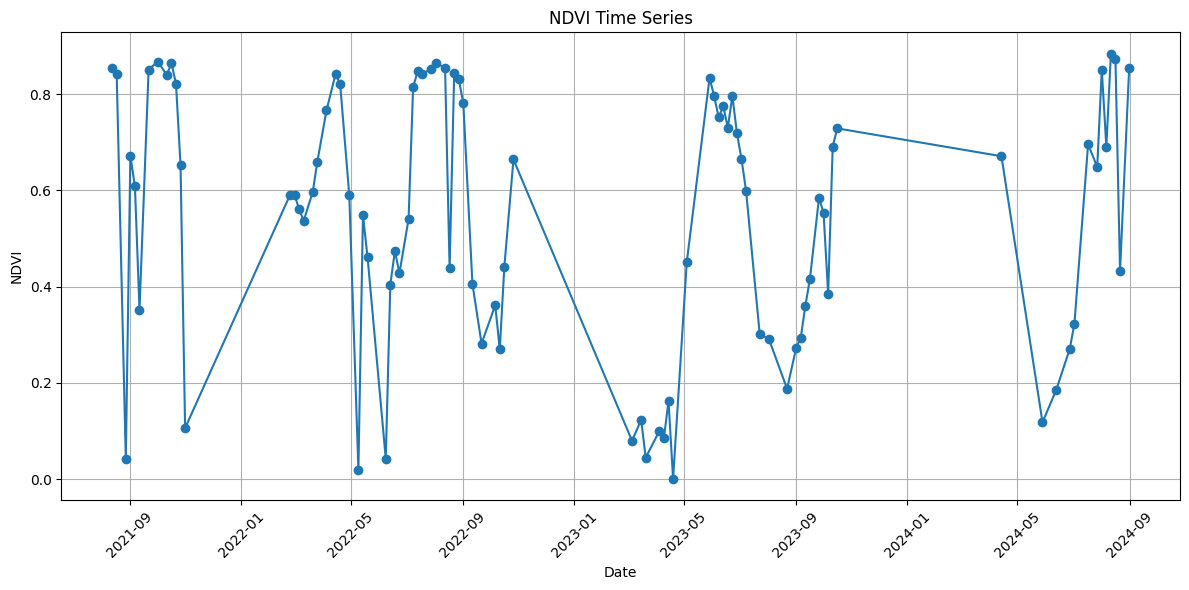

In [6]:
import matplotlib.pyplot as plt

# Filter the DataFrame to exclude zero NDVI values
filtered_df = df[df['NDVI'] > 0]

# Plotting the NDVI time series
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['date'], filtered_df['NDVI'], 'o-')
plt.title('NDVI Time Series')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Step 7: Display the data in a table

In [7]:
df

,date,NDVI
236,2021-08-09 10:15:59+00:00,0.000000
229,2021-08-10 10:40:31+00:00,0.000000
233,2021-08-12 10:25:59+00:00,0.853751
235,2021-08-14 10:20:31+00:00,0.000000
232,2021-08-15 10:36:29+00:00,0.000000
...,...,...
36,2024-08-23 10:15:59+00:00,0.000000
37,2024-08-24 10:40:21+00:00,0.000000
38,2024-08-28 10:20:21+00:00,0.000000
39,2024-08-29 10:36:29+00:00,0.000000
